In [6]:
import quandl
import pandas_datareader as pdr
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import copy
from tqdm import tqdm

In [9]:
# Macro economic indicators (mostly US) from the FRED database
# Detailed info on each indicator check on web: https://fred.stlouisfed.org/series/
# DOC with the metrics and external exploratory Colab: https://docs.google.com/document/d/1Cf4C3Xz4_yitlzPa
FRED_INDICATORS = ['GDP', 'GDPC1', 'GDPPOT', 'NYGDPMKTPCDWLD',         # 1. Growth
                   'CPIAUCSL', 'CPILFESL', 'GDPDEF',                   # 2. Prices and Inflation
                   'M1SL', 'WM1NS', 'WM2NS', 'M1V', 'M2V', 'WALCL',    # 3. Money Supply
                   'DFF', 'DTB3', 'DGS5', 'DGS10', 'DGS30', 'T5YIE',   # 4. Interest Rates
                   'T10YIE', 'T5YIFR', 'TEDRATE', 'DPRIME',            # 4. Interest Rates
                   'UNRATE', 'NROU', 'CIVPART', 'EMRATIO',             # 5. Employment
                   'UNEMPLOY', 'PAYEMS', 'MANEMP', 'ICSA', 'IC4WSA',   # 5. Employment
                   'CDSP', 'MDSP', 'FODSP', 'DSPIC96', 'PCE', 'PCEDG', # 6. Income and Expenditure
                   'PSAVERT', 'DSPI', 'RSXFS',                         # 6. Income and Expenditure
                   'INDPRO', 'TCU', 'HOUST', 'GPDI', 'CP', 'STLFSI2',  # 7. Other indicators
                   'DCOILWTICO', 'DTWEXAFEGS', 'DTWEXBGS',             # 7. Other indicators
                   'GFDEBTN', 'GFDEGDQ188S',                           # 8. Gov-t debt
                   # 9. Additional indicators from IVAN
                   'DEXUSEU', 'GVZCLS', 'VIXCLS', 'DIVIDEND',
                   # 9. Additional indicators from IVAN
                   'MORTGAGE30US', 'SPCS20RSA'
                   ]

In [11]:
# Macro Indicators from QUANDL
QUANDL_INDICATORS = {'BCHAIN/MKPRU', 'USTREASURY/YIELD', 'USTREASURY/REALYIELD',  # 9. Additional indicators from IVAN
                     # 9. Additional indicators from IVAN
                     'MULTPL/SHILLER_PE_RATIO_MONTH', 'LBMA/GOLD'
                     }

In [13]:
# Stock maret indexes
  # All indexes: https://stooq.com/t/ 
STOOQ_INDICATORS = {'^DJI','^SPX'}  

In [15]:
# update period for each ind (Y=Yearly, Q=Quarterly, M=Monthly, W=Weekly, D=Daily)
INDICATORS_PERIODS = {'GDP': 'Q', 'GDPC1': 'Q', 'GDPPOT': 'Q', 'NYGDPMKTPCDWLD': 'Y',                 # 1. Growth
                      # 2. Prices and Inflation
                      'CPIAUCSL': 'M', 'CPILFESL': 'M', 'GDPDEF': 'Q',
                      # 3. Money Supply
                      'M1SL': 'M', 'WM1NS': 'W', 'WM2NS': 'W', 'M1V': 'Q', 'M2V': 'Q', 'WALCL': 'W',
                      # 4. Interest Rates
                      'DFF': 'D', 'DTB3': 'D', 'DGS5': 'D', 'DGS10': 'D', 'DGS30': 'D', 'T5YIE': 'D',
                      # 4. Interest Rates
                      'T10YIE': 'D', 'T5YIFR': 'D', 'TEDRATE': 'D', 'DPRIME': 'D',
                      # 5. Employment
                      'UNRATE': 'M', 'NROU': 'Q', 'CIVPART': 'M', 'EMRATIO': 'M',
                      # 5. Employment
                      'UNEMPLOY': 'M', 'PAYEMS': 'M', 'MANEMP': 'M', 'ICSA': 'W', 'IC4WSA': 'W',
                      # 6. Income and Expenditure
                      'CDSP': 'Q', 'MDSP': 'Q', 'FODSP': 'Q', 'DSPIC96': 'M', 'PCE': 'M', 'PCEDG': 'M',
                      # 6. Income and Expenditure
                      'PSAVERT': 'M', 'DSPI': 'M', 'RSXFS': 'M',
                      # 7. Other indicators
                      'INDPRO': 'M', 'TCU': 'M', 'HOUST': 'M', 'GPDI': 'Q', 'CP': 'Q', 'STLFSI2': 'W',
                      # 7. Other indicators
                      'DCOILWTICO': 'D', 'DTWEXAFEGS': 'D', 'DTWEXBGS': 'D',
                      # 8. Gov-t debt
                      'GFDEBTN': 'Q', 'GFDEGDQ188S': 'Q',
                      # 9. FRED: Additional indicators from IVAN
                      'DEXUSEU': 'D', 'GVZCLS': 'D', 'VIXCLS': 'D', 'DIVIDEND': 'Q',
                      # 9. FRED: Additional indicators from IVAN
                      'MORTGAGE30US': 'W', 'SPCS20RSA': 'M',
                      # 9.QUANDL: Additional indicators from IVAN
                      'BCHAIN_MKPRU': 'D', 'USTREASURY_YIELD': 'D', 'USTREASURY_REALYIELD': 'D',
                      'MULTPL_SHILLER_PE_RATIO_MONTH': 'M', 'LBMA_GOLD': 'D',
                      # 10. INDEXES
                      'SPX': 'D', 'DJI': 'D'
                      }

In [16]:
end = date.today()
start = date(year=end.year-35, month=end.month, day=end.day)
macro_indicators = dict()
tq_fred = tqdm(FRED_INDICATORS)

# get the stats from FRED database (with Pandas Datareader API)
tq_fred.set_description('Downloading stats from FRED:')
for indicator in tq_fred:
  # tq_fred.set_description(indicator)
  # macro_indicators[indicator] = pdr.DataReader(indicator, "fred", start=start, timeout=90)
  macro_indicators[indicator] = pdr.fred.FredReader(indicator, start=start, timeout=90).read()
     

In [18]:
tq_quandl = tqdm(QUANDL_INDICATORS)
# get the stats from QUANDL database
tq_quandl.set_description("Downloading stats from QUANDL:")
for indicator in tq_quandl:
 # tq_quandl.set_description(indicator)
 # modify all indicator names '/': like "USTREASURY/YIELD" to "USTREASURY_YIELD"
 macro_indicators[indicator.replace("/", "_")] = quandl.get(indicator, start_date=start, end_date=end, authtoken="5qE7KbLemDiZ9RfNsVuM")

In [19]:
for indicator in tqdm(STOOQ_INDICATORS):
  macro_indicators[indicator.replace("^", "")]= pdr.get_data_stooq(indicator, start, end)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.48it/s]


In [25]:
# ORIGINAL STATS (need to reverse SPX and DJI):
macro_indicators['SPX'] = macro_indicators['SPX'].reindex(index=macro_indicators['SPX'].index[::-1])
macro_indicators['DJI'] = macro_indicators['DJI'].reindex(index=macro_indicators['DJI'].index[::-1])

In [29]:
# need to have a deep copy of macro indicators to make local transformations not changing the datarepo
macro_indicators_dict = copy.deepcopy(macro_indicators)

In [30]:
def get_macro_shift_transformation(macro_indicators_dict):
        """Add shifted (growth) values to the data_repo.macro_indicators before joining them together, remove non-stationary time series"""
        
        # Transform daily stats on this shift
        HISTORICAL_PERIODS_DAYS = [1, 3, 7, 30, 90, 365]
        
        # Different types of transformations for daily, weekly, monthly, indicators
        DoD_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'D']
        WoW_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'W']
        MoM_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'M']
        QoQ_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'Q']
        YoY_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'Y']

        # rename and drop some columns (especially from QUANDL)
        macro_indicators_dict['BCHAIN_MKPRU'].rename(
            columns={'Value': 'BCHAIN_MKPRU'}, inplace=True)
        macro_indicators_dict['MULTPL_SHILLER_PE_RATIO_MONTH'].rename(
            columns={'Value': 'MULTPL_SHILLER_PE_RATIO_MONTH'}, inplace=True)
        #  GOLD PRICE == evening (PM) value in USD on London Stock Exchange, drop all other columns
        macro_indicators_dict['LBMA_GOLD'].rename(
            columns={'USD (PM)': 'LBMA_GOLD'}, inplace=True)
        macro_indicators_dict['LBMA_GOLD'].drop(
            ['USD (AM)', 'GBP (AM)', 'GBP (PM)', 'EURO (AM)', 'EURO (PM)'], axis=1, inplace=True)
        
        # INDEXES: leave only Close price
        macro_indicators_dict['SPX'].drop(
            ['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
        macro_indicators_dict['SPX'].rename(
            columns={'Close': 'SPX'}, inplace=True)
        macro_indicators_dict['DJI'].drop(
            ['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
        macro_indicators_dict['DJI'].rename(
            columns={'Close': 'DJI'}, inplace=True)

        for ind in DoD_ind:
            # do transform only if oil_prices, blockchain_prices, gold_prices, indexes
            if not ind in {'DCOILWTICO', 'BCHAIN_MKPRU', 'LBMA_GOLD','SPX','DJI'}:
                continue
            # treat those as an index
            for i in HISTORICAL_PERIODS_DAYS:
                df = macro_indicators_dict[ind]
                ind_transformed = ind + '_growth_' + str(i)+'d'
                df[ind_transformed] = df[ind]/df[ind].shift(i)-1

        # future growth stats
        for ind in ['SPX','DJI']:
          for i in HISTORICAL_PERIODS_DAYS:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_future_growth_' + str(i)+'d'
            df[ind_transformed] = df[ind].shift(-i-1)/df[ind].shift(-1)-1

        for ind in WoW_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_wow'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_mom'
            df[ind_transformed] = df[ind]/df[ind].shift(5)-1
            # drop original "ind" column if series are non-stationary
            # do not drop original ind for FinStressIndex (STLFSI2), and Long-term Mortgage rates
            if not ind in {'STLFSI2', 'MORTGAGE30US'}:
                macro_indicators_dict[ind].drop(
                    [ind], axis=1, inplace=True)

        for ind in MoM_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_mom'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(12)-1
            # drop original "ind" column if series are non-stationary
            # do not drop original ind for all indicators that are 'ratios' or 'percentages'
            if not ind in {'UNRATE', 'CIVPART', 'EMRATIO', 'PSAVERT', 'INDPRO', 'TCU', 'SPCS20RSA', 'MULTPL_SHILLER_PE_RATIO_MONTH'}:
                macro_indicators_dict[ind].drop(
                    [ind], axis=1, inplace=True)

        # create one field as div_ratio (% of profits paid as dividents)
        macro_indicators_dict['CP'] = macro_indicators_dict['CP'].join(
            macro_indicators_dict['DIVIDEND'])
        macro_indicators_dict['CP']['div_ratio'] = macro_indicators_dict['CP']['DIVIDEND'] / \
            macro_indicators_dict['CP']['CP']
        macro_indicators_dict['CP'].drop(
            ['DIVIDEND'], axis=1, inplace=True)

        for ind in QoQ_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_qoq'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(4)-1
            # drop original "ind" column if series are non-stationary
            # do not drop original ind for all indicators that are 'ratios' or 'percentages'
            if not ind in {'GDPDEF', 'M1V', 'M2V', 'NROU', 'CDSP', 'MDSP', 'FODSP', 'GFDEGDQ188S'}:
                macro_indicators_dict[ind].drop(
                    [ind], axis=1, inplace=True)

        for ind in YoY_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            macro_indicators_dict[ind].drop([ind], axis=1, inplace=True)
     

In [31]:
get_macro_shift_transformation(macro_indicators_dict)

In [33]:
for i,value in enumerate(macro_indicators_dict.keys()):
  if i%6==0:
    print('\n')
  print(value, end =", ")



GDP, GDPC1, GDPPOT, NYGDPMKTPCDWLD, CPIAUCSL, CPILFESL, 

GDPDEF, M1SL, WM1NS, WM2NS, M1V, M2V, 

WALCL, DFF, DTB3, DGS5, DGS10, DGS30, 

T5YIE, T10YIE, T5YIFR, TEDRATE, DPRIME, UNRATE, 

NROU, CIVPART, EMRATIO, UNEMPLOY, PAYEMS, MANEMP, 

ICSA, IC4WSA, CDSP, MDSP, FODSP, DSPIC96, 

PCE, PCEDG, PSAVERT, DSPI, RSXFS, INDPRO, 

TCU, HOUST, GPDI, CP, STLFSI2, DCOILWTICO, 

DTWEXAFEGS, DTWEXBGS, GFDEBTN, GFDEGDQ188S, DEXUSEU, GVZCLS, 

VIXCLS, DIVIDEND, MORTGAGE30US, SPCS20RSA, MULTPL_SHILLER_PE_RATIO_MONTH, USTREASURY_YIELD, 

BCHAIN_MKPRU, LBMA_GOLD, USTREASURY_REALYIELD, DJI, SPX, 

In [35]:
dates = pd.DataFrame(macro_indicators_dict['SPX'].index.sort_values().unique(), columns=['Date'])

In [36]:
def get_daily_macro_stats_df(daily_df, macro_ind_df, regime='LAST'):
        """take Time from daily_df, and apply that to macro_ind_df, (LAST=take last observation, PREVIOUS=take previous) """
        ticker_dates = daily_df.Date.sort_values().unique()
        new_column_dict = {}

        for elem in ticker_dates:
            ts = pd.to_datetime(str(elem))
            d = ts.strftime('%Y-%m-%d')
            # all potential records to merge
            options_to_merge = macro_ind_df[macro_ind_df.index <= d]
            if len(options_to_merge) == 0:
                continue
            last_value = options_to_merge.tail(1).values.tolist()[0]
            prev_value = options_to_merge.tail(2).values.tolist()[0]
            if regime == 'PREVIOUS':
                if prev_value is not None:
                    new_column_dict[d] = prev_value
            elif regime == 'LAST':
                if last_value is not None:
                    new_column_dict[d] = last_value
            else:
                raise("Regime should be in ('PREVIOUS','LAST')")
        return pd.DataFrame.from_dict(new_column_dict, orient='index', columns = options_to_merge.keys())

In [37]:
# 2) Create a DAILY macro stats dataset
# Different types of joins for daily, weekly, monthly, indicators
  # join on the last available date
lastday_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v not in ('M', 'Q', 'Y')]
  # join on the previous available date (M,Q,Y stats write say '2021-01-01' - but they represent the whole M,Q,Y STARTING at this date)
firstday_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v in ('M', 'Q', 'Y')]

  # start from all dates we need to have macro stats
dates = pd.DataFrame(macro_indicators_dict['SPX'].index.sort_values().unique(), columns=['Date'])

macro_data_df = None
#  iterate over all transformed series in self.macro_indicators_dict and join one by one
# all non-Monthly indicators are
tq_last_day = tqdm(lastday_ind)
tq_last_day.set_description("Merging LAST Day indicators")
for ind in tq_last_day:
  # do not add some indicators to the final dataset (they are duplicated in another datasource)
  if ind in ('USTREASURY_YIELD', 'USTREASURY_REALYIELD'):
    continue
  df_to_merge = get_daily_macro_stats_df(dates, macro_indicators_dict[ind], regime='LAST')
  if macro_data_df is None:
    macro_data_df = df_to_merge
  else:
    macro_data_df = macro_data_df.join(df_to_merge)

tq_first_day = tqdm(firstday_ind)
tq_first_day.set_description("Merging FIRST Day indicators")
#  some stats  have first day of period date (e.g. '2020-06-01' instead of '2020-06-30'), so we need to get PREVIOUS available macro param
for ind in tq_first_day:
  df_to_merge = get_daily_macro_stats_df(dates, macro_indicators_dict[ind], regime='PREVIOUS')
  if macro_data_df is None:
    macro_data_df = df_to_merge
  else:
    macro_data_df = macro_data_df.join(df_to_merge)

Merging FIRST Day indicators: 100%|████████████████████████████████████████████████████| 36/36 [01:07<00:00,  1.88s/it]


In [38]:
# learn how to save a dataframe efficiently
macro_data_df.to_parquet('macro_df_small.parquet',compression='BROTLI')

In [39]:
macro_df = pd.read_parquet('macro_df_small.parquet')

In [40]:
i=1
for value in macro_df.keys():
  if not ('future' in value):
    print(value, end =", ")
    if i%8==0:
      print('\n')
    i+=1

WM1NS_wow, WM1NS_mom, WM2NS_wow, WM2NS_mom, WALCL_wow, WALCL_mom, DFF, DTB3, 

DGS5, DGS10, DGS30, T5YIE, T10YIE, T5YIFR, TEDRATE, DPRIME, 

ICSA_wow, ICSA_mom, IC4WSA_wow, IC4WSA_mom, STLFSI2, STLFSI2_wow, STLFSI2_mom, DCOILWTICO, 

DCOILWTICO_growth_1d, DCOILWTICO_growth_3d, DCOILWTICO_growth_7d, DCOILWTICO_growth_30d, DCOILWTICO_growth_90d, DCOILWTICO_growth_365d, DTWEXAFEGS, DTWEXBGS, 

DEXUSEU, GVZCLS, VIXCLS, MORTGAGE30US, MORTGAGE30US_wow, MORTGAGE30US_mom, BCHAIN_MKPRU, BCHAIN_MKPRU_growth_1d, 

BCHAIN_MKPRU_growth_3d, BCHAIN_MKPRU_growth_7d, BCHAIN_MKPRU_growth_30d, BCHAIN_MKPRU_growth_90d, BCHAIN_MKPRU_growth_365d, LBMA_GOLD, LBMA_GOLD_growth_1d, LBMA_GOLD_growth_3d, 

LBMA_GOLD_growth_7d, LBMA_GOLD_growth_30d, LBMA_GOLD_growth_90d, LBMA_GOLD_growth_365d, SPX, SPX_growth_1d, SPX_growth_3d, SPX_growth_7d, 

SPX_growth_30d, SPX_growth_90d, SPX_growth_365d, DJI, DJI_growth_1d, DJI_growth_3d, DJI_growth_7d, DJI_growth_30d, 

DJI_growth_90d, DJI_growth_365d, GDP_qoq, GDP_yoy, GDPC

In [41]:
pd.set_option('display.max_columns', 10)
macro_df.tail(1)
# pd.set_option('display.max_columns', None)

,WM1NS_wow,WM1NS_mom,WM2NS_wow,WM2NS_mom,WALCL_wow,...,SPCS20RSA_mom,SPCS20RSA_yoy,MULTPL_SHILLER_PE_RATIO_MONTH,MULTPL_SHILLER_PE_RATIO_MONTH_mom,MULTPL_SHILLER_PE_RATIO_MONTH_yoy
2022-12-15,0.001854,-0.006159,0.002715,0.000384,0.000079,...,-0.012951,0.130855,29.9,0.041449,-0.025106


In [42]:
macro_df.corr()

,WM1NS_wow,WM1NS_mom,WM2NS_wow,WM2NS_mom,WALCL_wow,...,SPCS20RSA_mom,SPCS20RSA_yoy,MULTPL_SHILLER_PE_RATIO_MONTH,MULTPL_SHILLER_PE_RATIO_MONTH_mom,MULTPL_SHILLER_PE_RATIO_MONTH_yoy
WM1NS_wow,1.000000,0.460199,0.025681,0.147259,0.041934,...,-0.005695,-0.008711,-0.000134,0.026409,-0.018008
WM1NS_mom,0.460199,1.000000,0.051213,0.326400,0.093041,...,-0.018350,-0.024045,0.000266,0.060791,-0.042740
WM2NS_wow,0.025681,0.051213,1.000000,0.525127,0.105518,...,-0.007153,-0.018754,0.026268,-0.017824,-0.015569
WM2NS_mom,0.147259,0.326400,0.525127,1.000000,0.239305,...,-0.026551,-0.052480,0.078922,-0.021302,-0.051762
WALCL_wow,0.041934,0.093041,0.105518,0.239305,1.000000,...,-0.089227,-0.123209,-0.079759,-0.128306,-0.082792
...,...,...,...,...,...,...,...,...,...,...,...
SPCS20RSA_mom,-0.005695,-0.018350,-0.007153,-0.026551,-0.089227,...,1.000000,0.773796,0.453581,0.146197,0.310125
SPCS20RSA_yoy,-0.008711,-0.024045,-0.018754,-0.052480,-0.123209,...,0.773796,1.000000,0.599496,0.077938,0.248235
MULTPL_SHILLER_PE_RATIO_MONTH,-0.000134,0.000266,0.026268,0.078922,-0.079759,...,0.453581,0.599496,1.000000,0.041294,0.177325
MULTPL_SHILLER_PE_RATIO_MONTH_mom,0.026409,0.060791,-0.017824,-0.021302,-0.128306,...,0.146197,0.077938,0.041294,1.000000,0.296197


In [43]:
SPX_growth_365d_corr = pd.DataFrame(macro_df.corr()['SPX_growth_365d'].sort_values())

In [44]:
SPX_growth_365d_corr.head()

,SPX_growth_365d
GVZCLS,-0.555892
STLFSI2,-0.516267
VIXCLS,-0.410169
FODSP,-0.328451
UNEMPLOY_yoy,-0.313115


In [45]:
SPX_growth_365d_corr.tail()

,SPX_growth_365d
MANEMP_yoy,0.570289
INDPRO_yoy,0.589332
MULTPL_SHILLER_PE_RATIO_MONTH_yoy,0.752853
DJI_growth_365d,0.951697
SPX_growth_365d,1.000000


<AxesSubplot: >

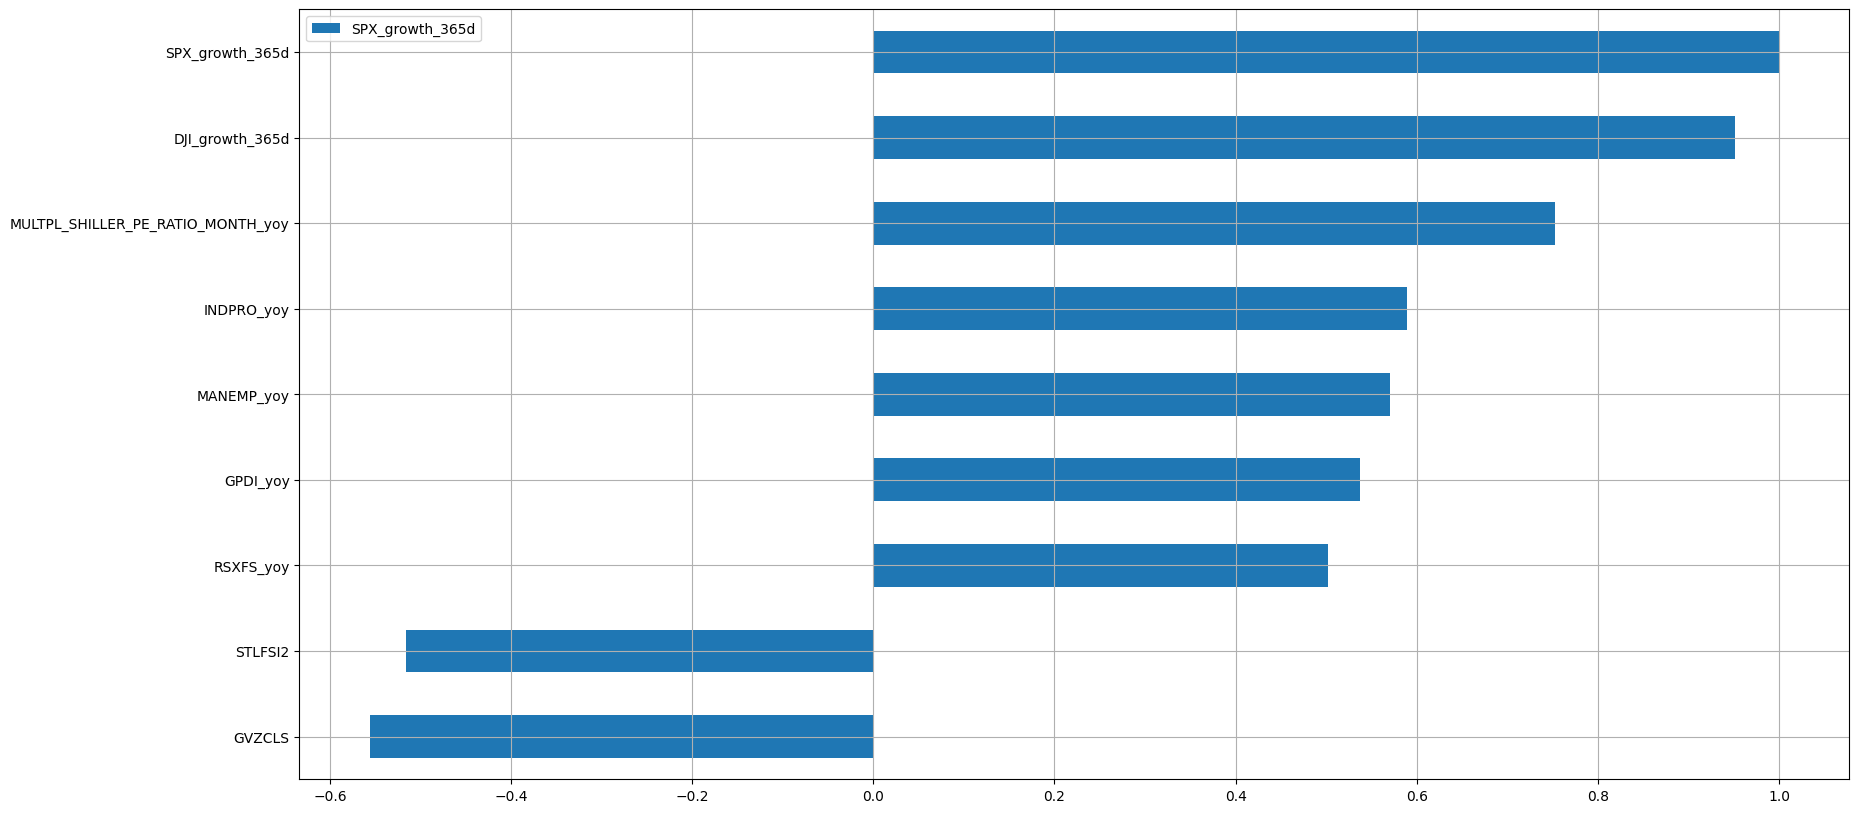

In [46]:
filter = np.abs(SPX_growth_365d_corr.SPX_growth_365d)>=0.5
SPX_growth_365d_corr[filter].plot.barh(figsize=(20,10), grid=True)